<a href="https://colab.research.google.com/github/Cassi686/Cassi686/blob/main/ecommerce_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pyspark # instalando biblioteca

In [ ]:
# importando biblioteca
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import zscore
from pyspark.sql import SparkSession
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.cluster import  k_means, dbscan, mean_shift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.datasets import make_blobs
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer
import string
from ipywidgets import interact
from yellowbrick.cluster import KElbowVisualizer
from pyspark.sql import SparkSession


Dataframe

In [ ]:
df = pd.read_csv("/content/data.csv", encoding = 'ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Data Understand

In [ ]:
df.columns # Observando as colunas

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
df.shape # Dimensões do datafrae - Linhas 541909 colunas 8

(541909, 8)

In [ ]:
df.info() # Tipos de dados das colunas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.describe() # Descriçao do dataframe

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
df.isnull().sum() # Verificand dados nulos

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
df.duplicated() # Observando valores duplicados

0         False
1         False
2         False
3         False
4         False
          ...  
541904    False
541905    False
541906    False
541907    False
541908    False
Length: 541909, dtype: bool

In [ ]:
df.duplicated().sum() # Total de duplicatas

5268

Data Visualization

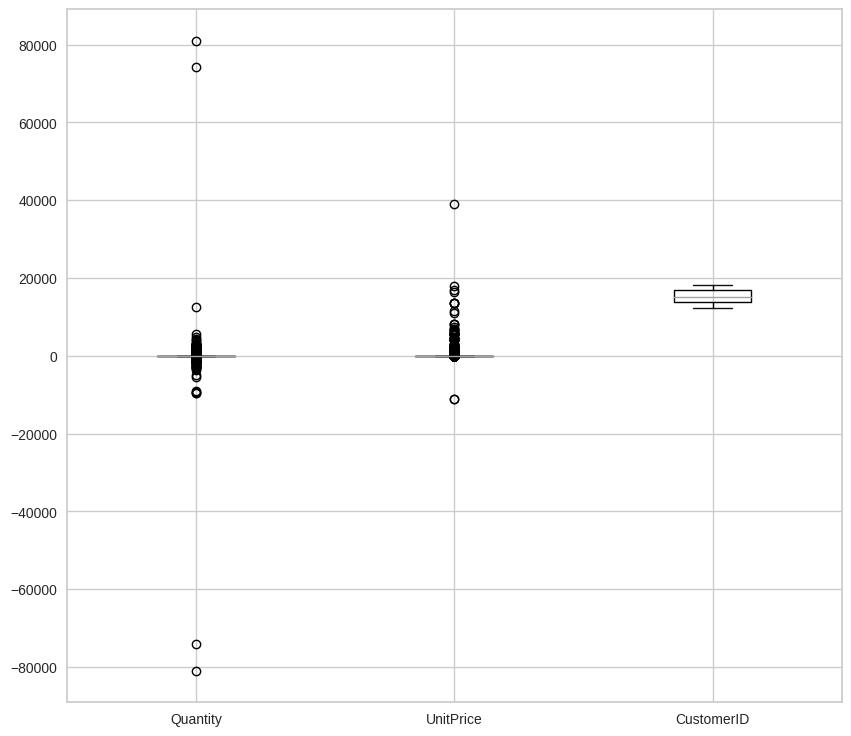

In [ ]:
df.boxplot(figsize=(10,9));

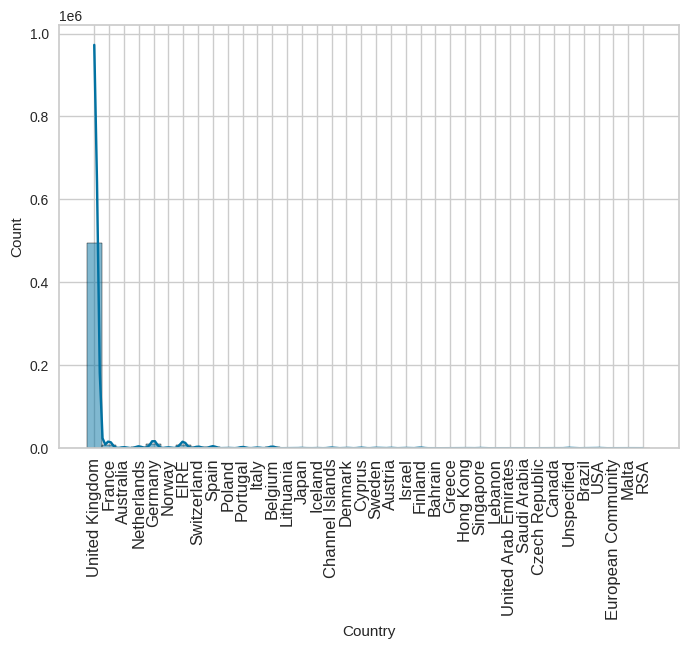

In [ ]:
sns.histplot(data=df, x='Country', kde = True)
plt.tick_params(axis='x', labelsize = 12, rotation = 90);

Data Preparetion

In [ ]:
df_copy = df.copy()

In [ ]:
# Removendo vlores nulos
df =df.dropna()

In [ ]:

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
df['CustomerID']= df['CustomerID'].astype(int) # Transformado coluna em int

In [ ]:
# Convertendo a coluna "InvoiceDate" para Datetime

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

RFM

São 3 métricas utilizadas para análise de clientes em estratégia de marketing. Significa Recency, Frequency and Monetary Value. Recência, Frequência e Valor monetário.

Recência - tempo decorrido desde a última intereçao entre o cliente e a empresa.

Frequência - Frequência em que o cliente realiza interações com a empresa.

Valor Monetário - Valor total gasto por um cliente em determinado período.



Recency:

In [ ]:
# Obtendo a data mmais recente presente no dataframe

data_mais_recente = df['InvoiceDate'].max()
data_mais_recente

Timestamp('2011-12-09 12:50:00')

In [ ]:
# Calculando a recêencia em dias

df_recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
df_recency['Recency'] = (data_mais_recente - df_recency['InvoiceDate']).dt.days
df_recency = df_recency.drop('InvoiceDate',axis=1)

In [ ]:
df_recency.head(3)

,CustomerID,Recency
0,12346,325
1,12347,1
2,12348,74


Frequency:

In [ ]:
df_frequency = df.groupby('CustomerID').agg({'InvoiceDate':'count'}).reset_index()
df_frequency = df_frequency.rename(columns={'InvoiceDate':'Frequency'})

In [ ]:
df_frequency.head(3)

,CustomerID,Frequency
0,12346,2
1,12347,182
2,12348,31


Monetary value:

In [ ]:
df_monetary_value = df
df_monetary_value['MonetaryValue'] = df['Quantity'] * df['UnitPrice']
df_monetary_value = df_monetary_value.groupby('CustomerID').agg({'MonetaryValue':'sum'}).reset_index()


In [ ]:
df_monetary_value.head(3)

,CustomerID,MonetaryValue
0,12346,0.00
1,12347,4310.00
2,12348,1797.24


RFV :

Merge:

In [ ]:
# Merge entre df_recency e df_frequency
df_rfv = pd.merge(df_recency, df_frequency, on = 'CustomerID', how = 'inner')

# Merge com Monetary_Value

df_rfv = pd.merge(df_rfv, df_monetary_value, on = 'CustomerID', how = 'inner')

In [ ]:
df_rfv.head(3)

,CustomerID,Recency,Frequency,MonetaryValue
0,12346,325,2,0.00
1,12347,1,182,4310.00
2,12348,74,31,1797.24


Data visualization

<Axes: >

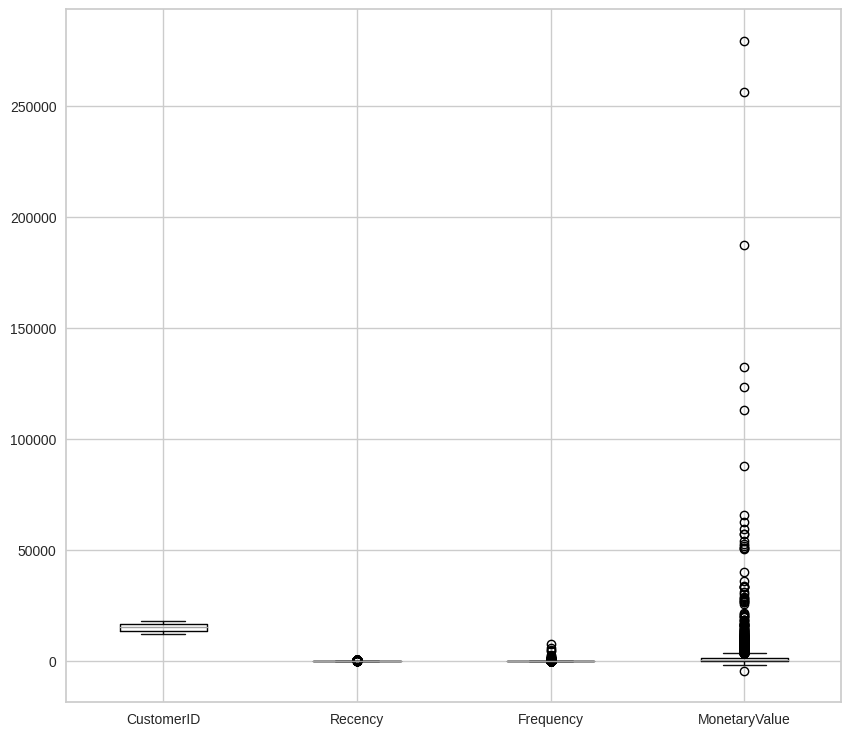

In [ ]:
df_rfv.boxplot(figsize = (10,9))

<Axes: >

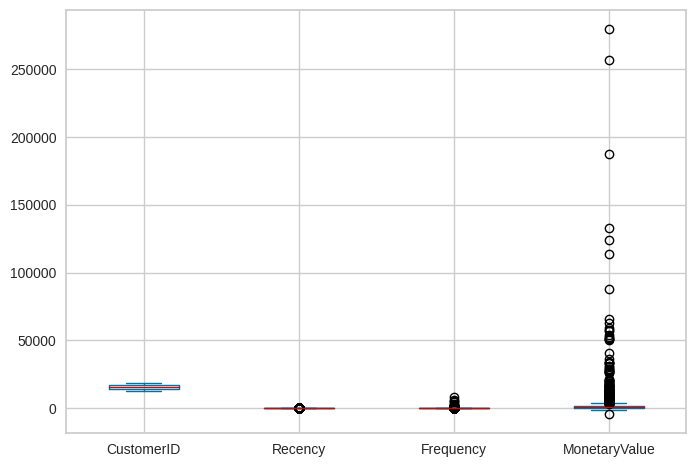

In [ ]:
df_rfv.plot.box()

In [ ]:
Recency = df_rfv['Recency']
Frequency = df_rfv['Frequency']
Monetary_Value = df_rfv['MonetaryValue']


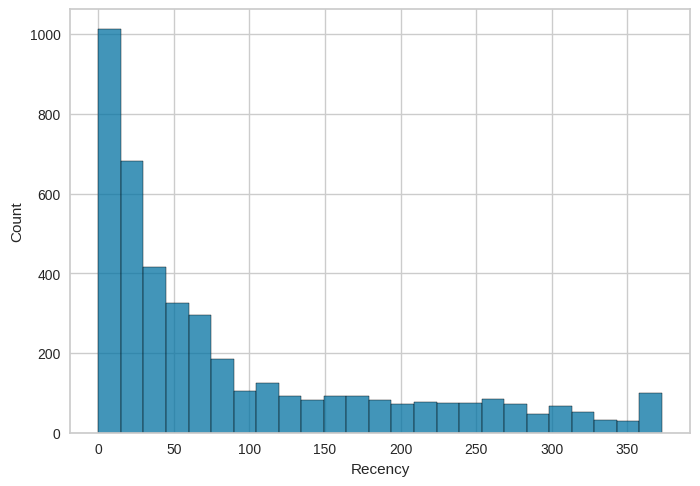

In [ ]:
sns.histplot(data=Recency);

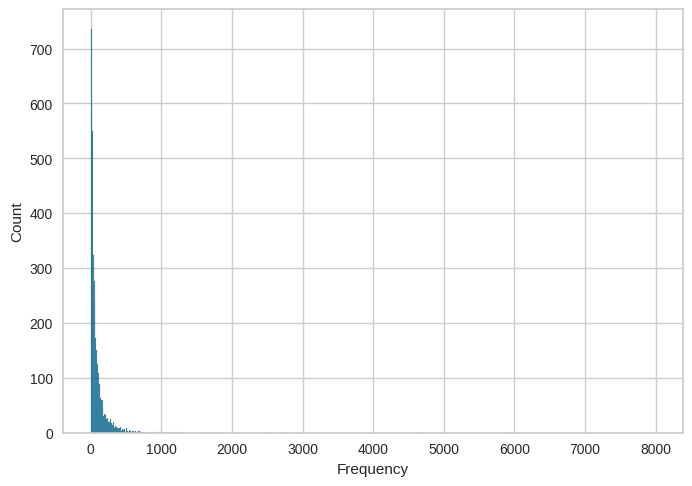

In [ ]:
sns.histplot(data=Frequency);

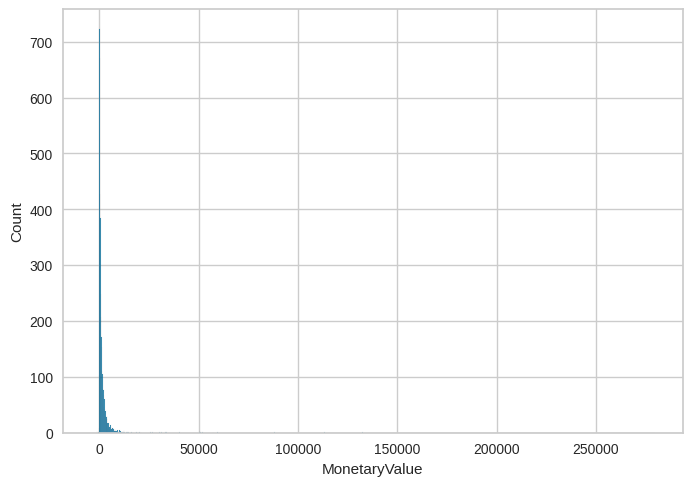

In [ ]:
sns.histplot(data=Monetary_Value);

Data Preparetion:

In [ ]:
# Colunas numéricas

colunas = ['Recency', 'Frequency', 'MonetaryValue']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
for coluna in colunas:
  df_rfv[coluna] = MinMaxScaler().fit_transform(np.array(df_rfv[coluna]).reshape(-1,1)) # Normalizando colunas do dataframe

In [ ]:
# removendo nulos

df_rfv = df_rfv.dropna()

In [ ]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import normalize

In [ ]:
df_rfv = df_rfv.apply(np.log) # corrigindo outliers

<Axes: >

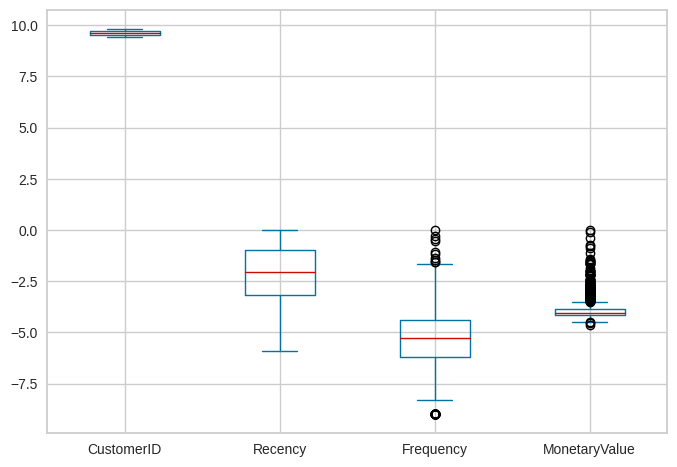

In [ ]:
df_rfv.plot.box()

In [ ]:
Recency1 = df_rfv['Recency']
Frequency1 = df_rfv['Frequency']
Monetary_Value1 = df_rfv['MonetaryValue']

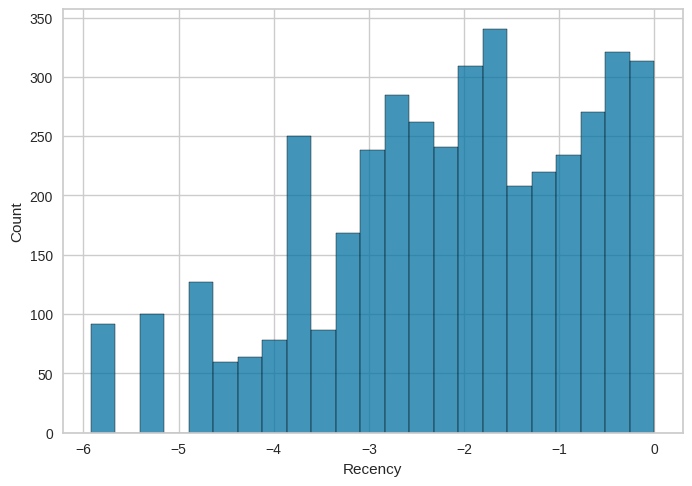

In [ ]:
sns.histplot(data=Recency1);

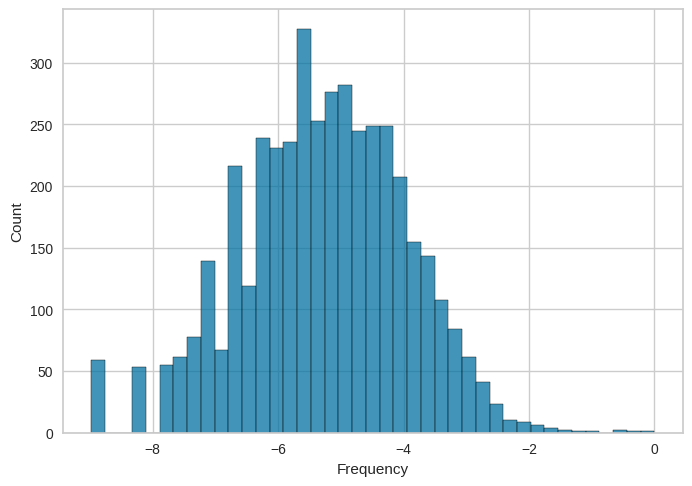

In [ ]:
sns.histplot(data=Frequency1);

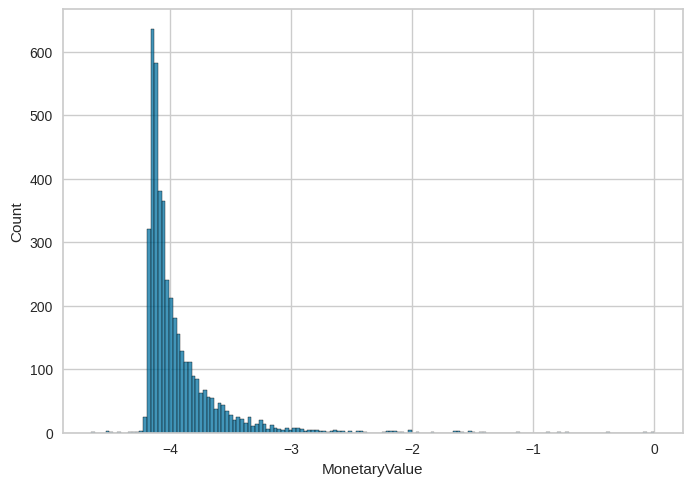

In [ ]:
sns.histplot(data=Monetary_Value1);

In [ ]:
sns.set_theme(
    context = 'talk',
    style= 'ticks',
    font_scale=.8,
    palette= 'tab10',
    rc={
        'figure.figsize':(12,8),
        'axes.grid':True,
        'grid.alpha':.2,
        'axes.titlesize':'x-large',
        'axes.titleweight':'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette='viridis', alpha= 0.8, linewidth= 0)

In [ ]:
df_rfv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4371
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     4372 non-null   float64
 1   Recency        4372 non-null   float64
 2   Frequency      4372 non-null   float64
 3   MonetaryValue  4372 non-null   float64
dtypes: float64(4)
memory usage: 170.8 KB


In [ ]:
X,y = datasets.make_blobs(n_samples=int(5E3), n_features=3, centers = 5,cluster_std=0.8)
df_cl = pd.DataFrame(X,columns=list(string.ascii_uppercase[:X.shape[1]]))
df_cl.head()

,A,B,C
0,4.883525,4.996817,1.980697
1,-5.918897,3.592476,-5.590821
2,4.706360,4.142027,2.493059
3,4.194173,6.857451,3.233955
4,-4.704184,2.585839,-5.875781


<Axes: xlabel='A', ylabel='B'>

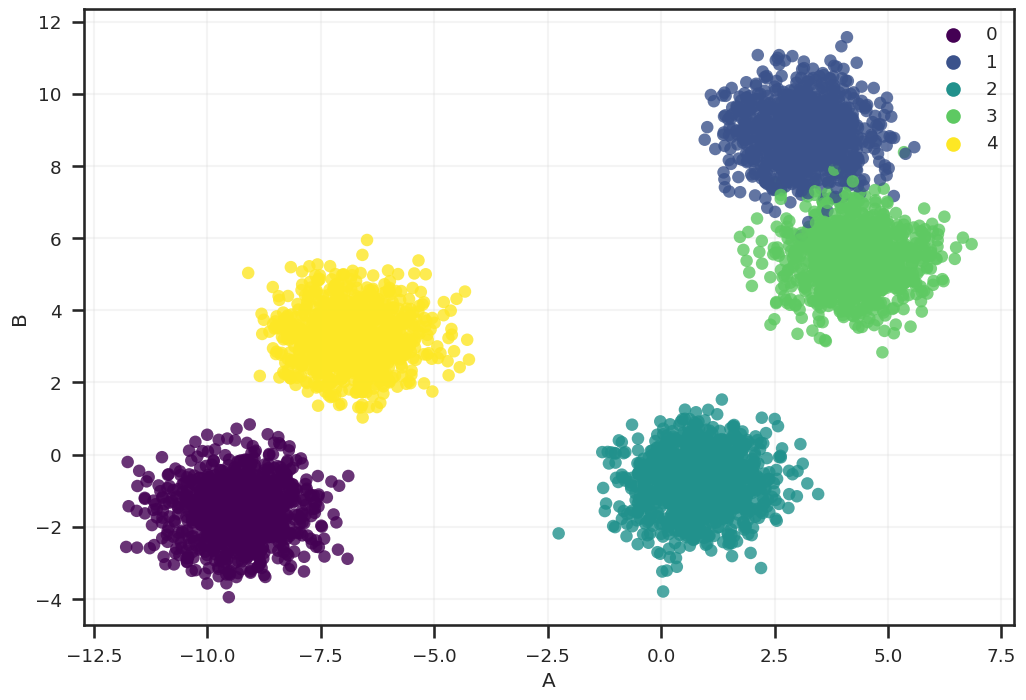

In [ ]:
sns.scatterplot(data=df_cl, x='A', y='B', hue=y, ** scatter_kwargs)

In [ ]:
centroids, labels, inertia = k_means(X,n_clusters=5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='A', ylabel='B'>

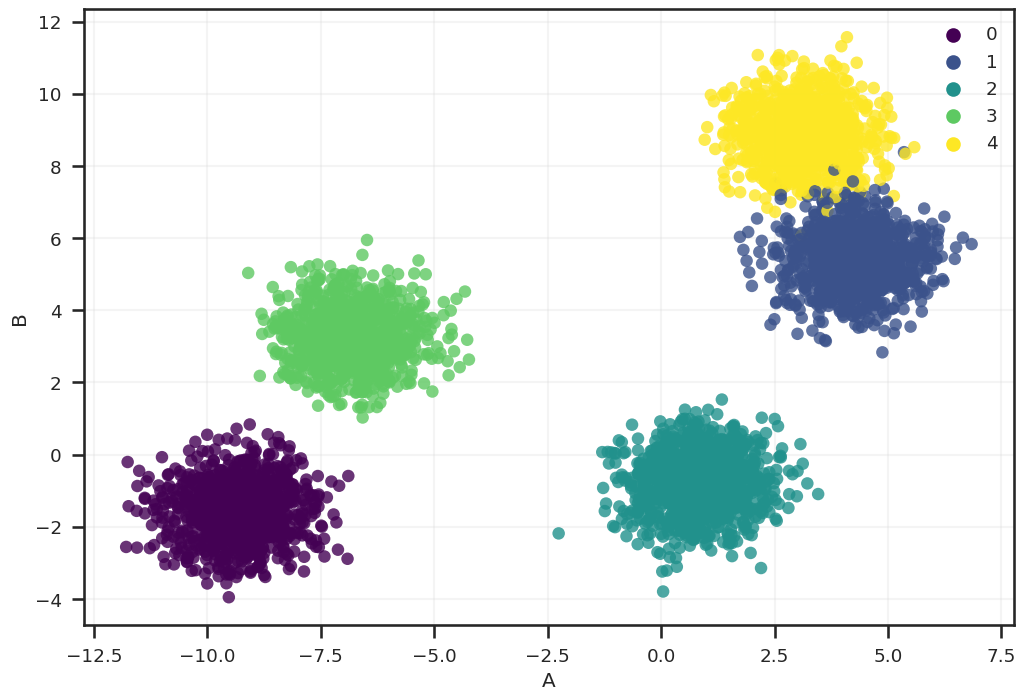

In [ ]:
sns.scatterplot(data=df_cl, x='A', y='B', hue=labels, ** scatter_kwargs)

In [ ]:
modelo = KMeans(n_clusters=5)
modelo.fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [ ]:
centroids = modelo.cluster_centers_
labels = modelo.labels_
inertia = modelo.inertia_

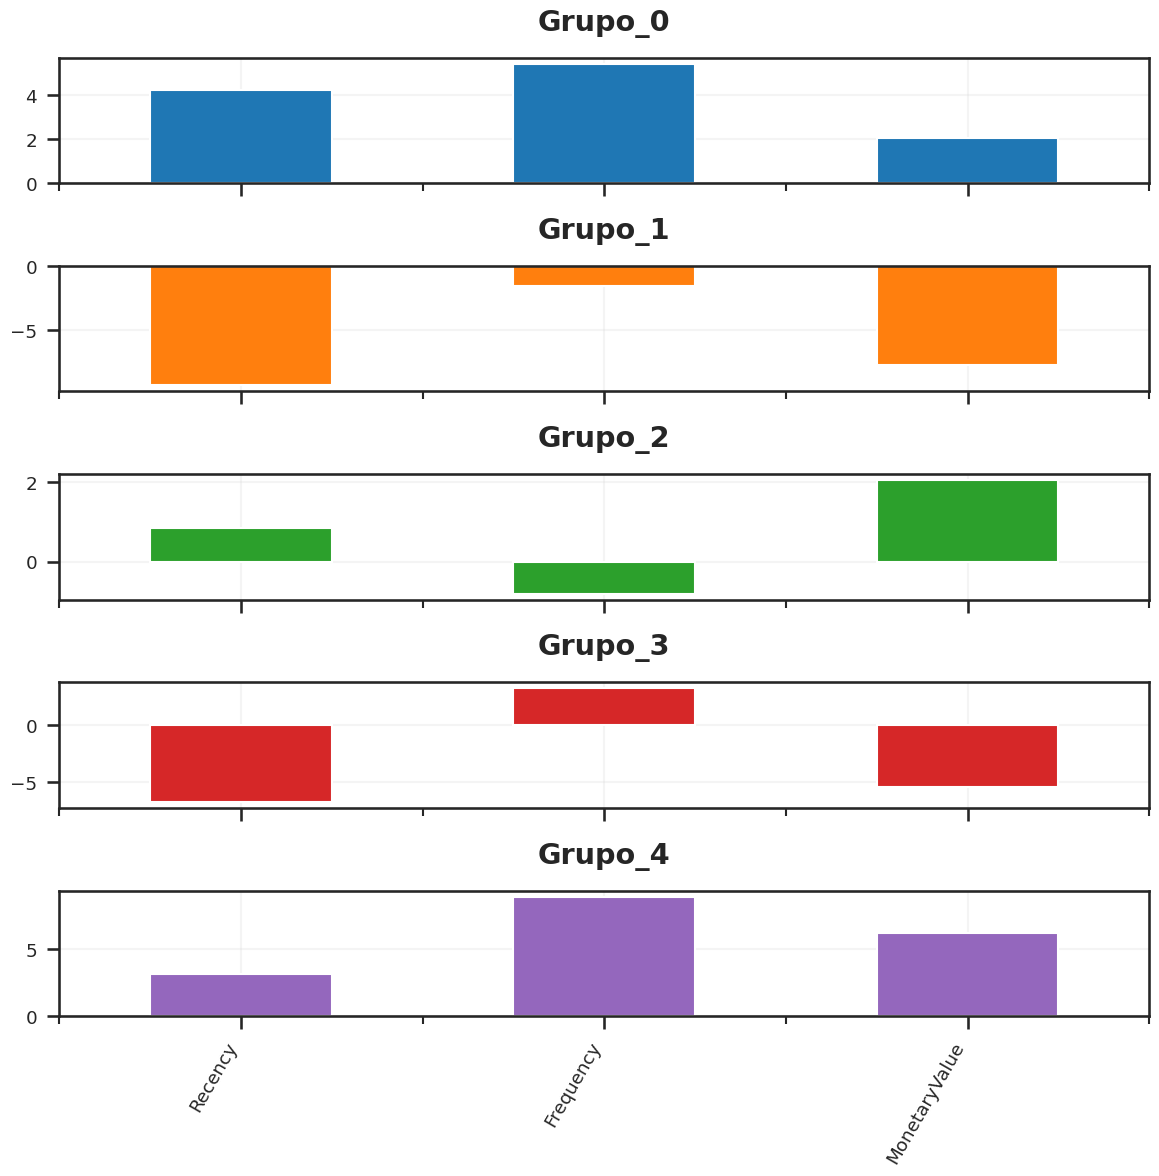

In [ ]:
(
  pd.DataFrame(centroids, columns=colunas)
  .T.add_prefix('Grupo_')
  .plot.bar(subplots=True, figsize=(12,12), legend=False)
)

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
centers = pd.DataFrame(centroids, columns=colunas)
display(centers)

,Recency,Frequency,MonetaryValue
0,4.251121,5.421002,2.074390
1,-9.308148,-1.545518,-7.747901
2,0.848240,-0.811084,2.053286
3,-6.793382,3.242745,-5.424070
4,3.140323,8.887326,6.150686


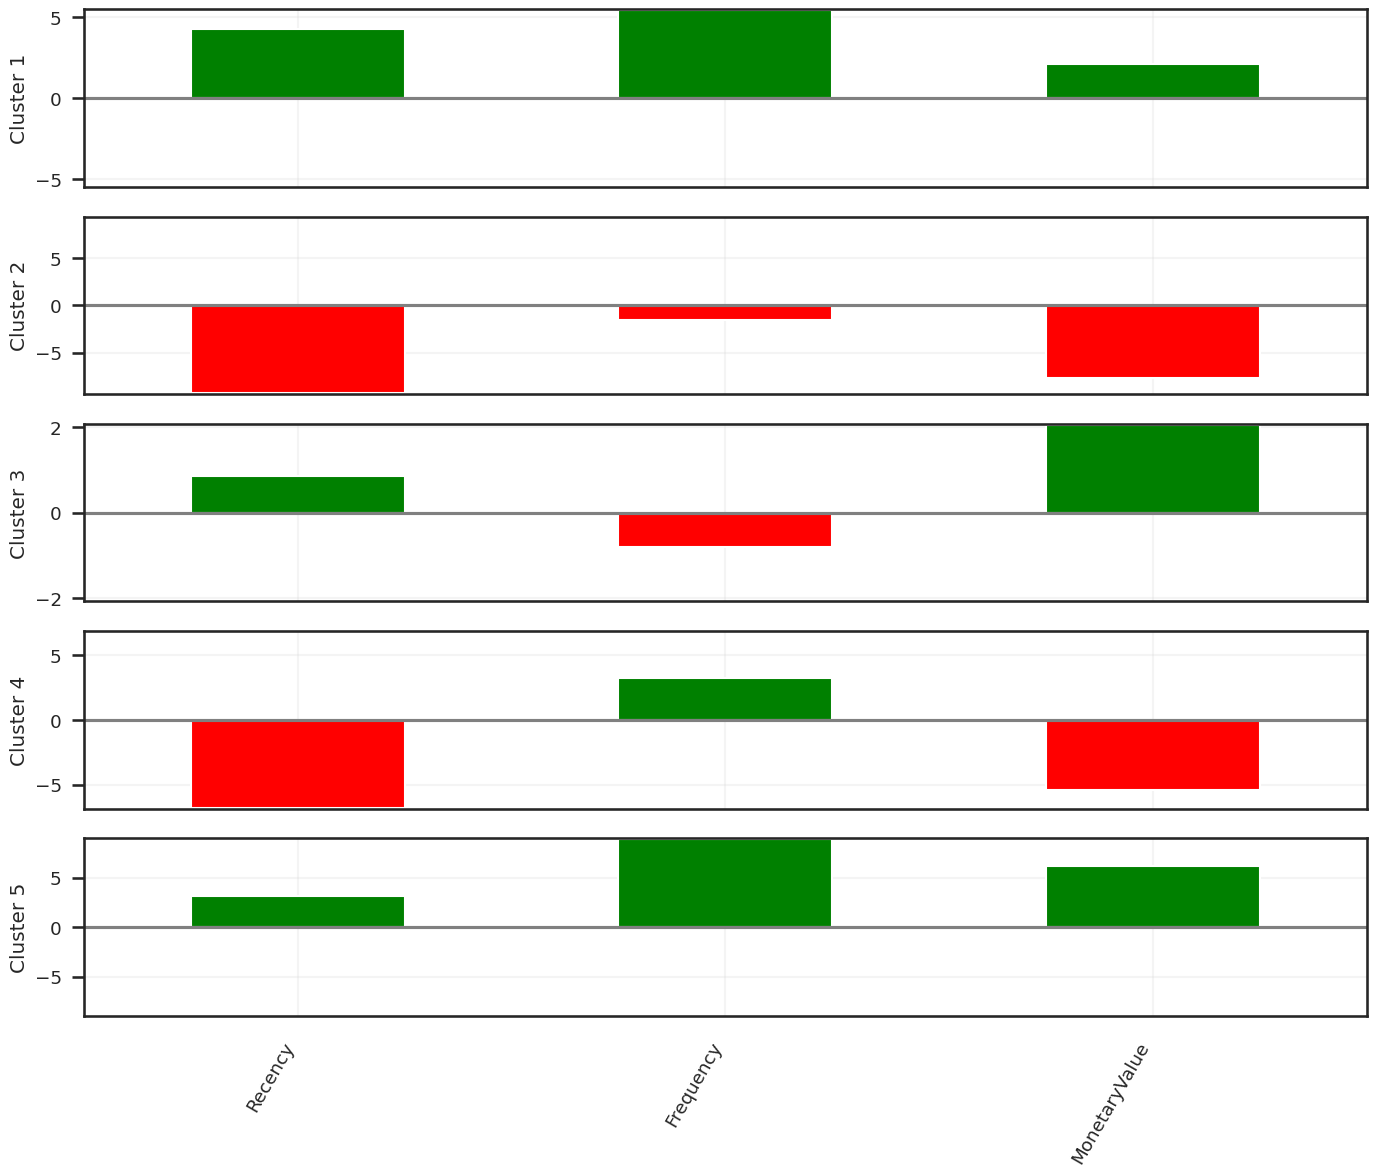

In [ ]:
fig, axes = plt.subplots(nrows=5, figsize=(14,12), sharex=True)

for i, ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

Perfil 1 : bom desempenho de recência, ótima frequência e valor monetário positivo.

Perfil 2: grupo ruim, péssima recência, baixa frequência e baixo valor monetário.

Perfil 3: grupo interessante, boa recência, baixa frequência, valor monetário positivo.

Perfil 4: Grupo ruim, baixa recência, frequência boa, mas baixo valor monetário.

Perfil 5 : O melhor grupo. boa recência, alta frequência, e o melhor valor monetário entre todos os perfis.

Conclusão:

Aconselho dar ênfase no perfil 5, atenção no perfil 1 e 3. Empregar menor energia nos grupos 2 e 4.